In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

from keras.models import Sequential
from keras.layers import Dense

from keras.models import Model
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Flatten
from keras import regularizers
from keras.layers.merge import concatenate

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.stats import ks_2samp

os.chdir('../src/')
import ml_analysis_plotting

Using TensorFlow backend.


In [2]:
def  get_input_arrays(tree, features_list):
    array = np.transpose(tree.arrays(features_list, outputtype=tuple))
    print(array.shape)
    print(array[0])
    return array

def plot_dnn_features(arrays, features_list, nBins=25):   
    
    arrays_shape = arrays.shape
    print(arrays_shape)
    arrays = np.transpose(arrays)
    
    fig, ax = plt.subplots(int(arrays_shape[1]),3, figsize=(15, 9))
    print(arrays_shape[1])
    
    feature_n = 0
    
    for j in range(int(arrays_shape[1]/2.)):            
            
        for k in range(3):
            
            if feature_n <= arrays_shape[1] - 1:
                
                ax[j,k].hist(arrays[feature_n], bins=nBins)
                ax[j,k].set_title(features_list[feature_n])
                feature_n += 1
            else:
                break

In [3]:
os.chdir('../data')

In [4]:
tree = uproot.open('user.pavol.19077317._000001.reco_copy.root')[b'newtree;1']
tree.keys()

[b't_pt',
 b't_eta',
 b't_phi',
 b'tbar_pt',
 b'tbar_eta',
 b'tbar_phi',
 b'dilepton',
 b'lep_t_pt',
 b'lep_t_eta',
 b'lep_t_phi',
 b'lep_tbar_pt',
 b'lep_tbar_eta',
 b'lep_tbar_phi',
 b'nu_t_pt',
 b'nu_t_eta',
 b'nu_t_phi',
 b'nu_tbar_pt',
 b'nu_tbar_eta',
 b'nu_tbar_phi',
 b'ttbar_pt',
 b'kk']

In [5]:
features_list = [b'lep_t_pt',
 b'lep_t_eta',
 b'lep_t_phi',
 b'lep_tbar_pt',
 b'lep_tbar_eta',
 b'lep_tbar_phi',
 b'nu_t_pt',
 b'nu_t_eta',
 b'nu_t_phi',
 b'nu_tbar_pt',
 b'nu_tbar_eta',
 b'nu_tbar_phi']

(array([  16.,   51.,  102.,  128.,  210.,  326.,  381.,  579.,  741.,
         983., 1302., 1866., 3641., 2401., 1553., 1224.,  896.,  698.,
         522.,  413.,  302.,  169.,  130.,   64.,   34.]),
 array([-0.98662063, -0.90889421, -0.8311678 , -0.75344138, -0.67571497,
        -0.59798855, -0.52026214, -0.44253572, -0.36480931, -0.2870829 ,
        -0.20935648, -0.13163007, -0.05390365,  0.02382276,  0.10154918,
         0.17927559,  0.25700201,  0.33472842,  0.41245484,  0.49018125,
         0.56790767,  0.64563408,  0.72336049,  0.80108691,  0.87881332,
         0.95653974]),
 <a list of 25 Patch objects>)

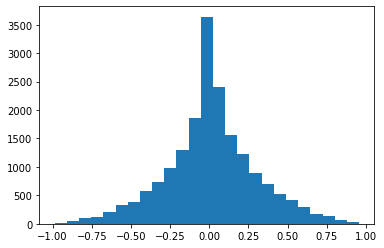

In [6]:
spin_target = tree.array(b'kk')
pt_cut = np.where(spin_target/1000.0 < 300.)[0]
spin_target = spin_target[pt_cut]
plt.hist(spin_target, bins=25)

In [7]:
spin_transformer = RobustScaler()
spin_target_scaled = spin_transformer.fit_transform(spin_target.reshape(-1,1))
spin_target_scaled = (spin_target_scaled - np.min(spin_target_scaled))/(np.max(spin_target_scaled) - np.min(spin_target_scaled))
print(spin_target_scaled.shape)

(18732, 1)


In [8]:
features_array = get_input_arrays(tree, features_list)

(18732, 12)
[ 5.10136289e+04 -1.21019089e+00 -2.41409278e+00  2.97444473e+04
  4.01265115e-01  2.66073322e+00  6.36220625e+04 -1.14657331e+00
 -2.97279501e+00  4.98950000e+04  9.59004343e-01 -5.63833117e-01]


In [9]:
np.where(np.isnan(features_array) == True)

(array([], dtype=int64), array([], dtype=int64))

In [10]:
features_array = features_array[pt_cut]

In [11]:
transformer = RobustScaler()
features_array_scaled = transformer.fit_transform(features_array)
print(features_array_scaled.shape)

(18732, 12)


In [20]:
def multihead_model():

    t_input = Input(shape=(6,) , name="t_input")
    
    nu_input = Input(shape=(6,) , name="nu_input")
    
    t1 = Dense(200, activation="relu")(t_input)
    #x2 = Dropout(0.2)(x2)
    t2 = Dense(100, activation="relu")(t1)
    #x2 = Dropout(0.2)(x2)
    t3 = Dense(50, activation="relu")(t2)
    #x2 = Dropout(0.2)(x2)
    
    nu1 = Dense(200, activation="relu")(nu_input)
    #x2 = Dropout(0.2)(x2)
    nu2 = Dense(100, activation="relu")(nu1)
    #x2 = Dropout(0.2)(x2)
    nu3 = Dense(50, activation="relu")(nu2)
    #x2 = Dropout(0.2)(x2)

    x = concatenate([t3, nu3])

    x = Dense(25, activation="relu")(x)
    #x = Dropout(0.2)(x)
    #x = Dense(32, activation="relu")(x)
    #x = Dropout(0.2)(x)

    output = Dense(1, activation="sigmoid", name="main_output")(x)

    model = Model(inputs=[t_input, nu_input], outputs=output)

    return model

In [21]:
mhModel = multihead_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
mhModel.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [24]:
features_array_scaled, spin_target_scaled = shuffle(features_array_scaled, spin_target_scaled)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features_array_scaled, spin_target_scaled, test_size=0.2)

In [34]:
l_train = np.transpose(np.transpose(X_train)[:6])
nu_train = np.transpose(np.transpose(X_train)[6:])

In [35]:
history = mhModel.fit([l_train, nu_train], y_train, epochs=500, batch_size=10, verbose=2)


Epoch 1/500
 - 2s - loss: 0.1068 - mae: 0.1068
Epoch 2/500
 - 2s - loss: 0.1054 - mae: 0.1054
Epoch 3/500
 - 2s - loss: 0.1045 - mae: 0.1045
Epoch 4/500
 - 2s - loss: 0.1036 - mae: 0.1036
Epoch 5/500
 - 2s - loss: 0.1033 - mae: 0.1033
Epoch 6/500
 - 2s - loss: 0.1026 - mae: 0.1026
Epoch 7/500
 - 2s - loss: 0.1024 - mae: 0.1024
Epoch 8/500
 - 2s - loss: 0.1019 - mae: 0.1019
Epoch 9/500
 - 2s - loss: 0.1014 - mae: 0.1014
Epoch 10/500
 - 2s - loss: 0.1010 - mae: 0.1010
Epoch 11/500
 - 2s - loss: 0.1003 - mae: 0.1003
Epoch 12/500
 - 2s - loss: 0.0997 - mae: 0.0997
Epoch 13/500
 - 2s - loss: 0.0992 - mae: 0.0992
Epoch 14/500


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.scatter(range(len(history.history['loss'])),history.history['loss'])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape

In [ ]:
class make_hist_dicts:

    def correct_compare_hist(self,
        array1, array2, nBins=40, normed=False, gauss=False, logY=False
    ):
        array1_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}
        array2_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}

        array1 = self.removeNan(array1)
        array2 = self.removeNan(array2)

        if gauss is True:
            ratio = guassian_comparison_ratio(array1, array2, nBins)
        else:
            ratio = np.ones(nBins)
        
        hist1, bins1, hist2, bins2 = self.get_hists(array1, array2, nBins)

        b1 = np.zeros(len(hist1))
        w1 = np.zeros(len(hist1))
        for i in range(len(hist1)):
            b1[i] = (bins1[i + 1] + bins1[i]) / 2
            w1[i] = bins1[i + 1] - bins1[i]
        b2 = b1
        w2 = w1
        
        array1_dict["binDx"] = w1
        array2_dict["binDx"] = w2

        fig, ax = plt.subplots(figsize=(16, 10))
        plt.cla()
        if logY is True:
            ax.set_yscale("log")
        ax.set_title("Regression Analysis - model 3, Batches", fontsize=35)
        ax.set_xlabel("Jet Mass", fontsize=24)
        ax.set_ylabel("Arbitraty Units", fontsize=24)
        
        
        array1_dict["hist"] = hist1
        array2_dict["hist"] = hist2
        
        array1_dict["binx"] = b1
        array2_dict["binx"] = b2
        
        hist1 = np.multiply(hist1, ratio)
        hist2 = np.multiply(hist2, ratio)

        weights1 = self.get_weights(array1, bins1, ratio)
        weights2 = self.get_weights(array2, bins2, ratio)
        
        array1_dict["weights"] = weights1
        array2_dict["weights"] = weights2

        if normed is False:
            scale1 = np.maximum(np.max(hist1), np.max(hist2))
            scale2 = scale1
        else:
            scale1 = np.max(hist1)
            scale2 = np.max(hist2)
        

        plt.bar(b1, hist1 / scale1, width=w1, alpha=0.2, color="blue", label="Truth")
        plt.bar(b2, hist2 / scale2, width=w2, alpha=0.2, color="red", label="Prediction")
        plt.bar(
            b1,
            hist1 / scale1,
            width=w1,
            alpha=1.0,
            color="none",
            edgecolor="blue",
            linewidth=2.0,
        )
        plt.bar(
            b2,
            hist2 / scale2,
            width=w2,
            alpha=1.0,
            color="none",
            edgecolor="red",
            linewidth=2.0,
        )
        plt.legend()
        plt.show()
        
        return array1_dict, array2_dict, ratio

    def removeNan(self,array):
        if len(np.where(np.isnan(array) is True)) == 0:
            pass
        return array[np.logical_not(np.isnan(array))]

    def get_hists(self, array1, array2, nBins):

        """
        array1 = (
            2 * (array1 - np.min(array1)) / (np.max(array1) - np.min(array1)) - 1
        )
        array2 = (
            2 * (array2 - np.min(array2)) / (np.max(array2) - np.min(array2)) - 1
        )
        """

        hist1, bins1, _ = plt.hist(
            array2, color="blue", alpha=0.2, bins=nBins
        )  # , weights=true_z_w)
        plt.close()
        bins2 = bins1
        hist2 = np.zeros(len(hist1))

        # z_reg = np.multiply(test_z_torch.data.numpy().reshape(1000), test_z_w)
        # z_reg = test_z_torch.data.numpy().reshape(len(true_z))
        # z_reg = test_z_torch

        for i in range(len(hist1)):
            hist2[i] = len(
                np.where(array1[np.where((array1 <= bins1[i + 1]))[0]] > bins1[i])[0]
            )  # & (z_reg > bins1[i])[0])]))
            if i == len(hist1):
                hist2[i] = len(np.where(array1 >= bins1[i])[0])
        return hist1, bins1, hist2, bins2

    def get_weights(self, array, bins, ratio):

        weights = np.zeros(len(array))
        bins = np.digitize(array, bins)

        for i in range(len(ratio)):
            weights[np.where(bins == i)] = ratio[i]

        return weights

In [ ]:
y_y = spin_transformer.fit_transform(y_test.reshape(-1,1))
y_y = (y_y - np.min(y_y))/(np.max(y_y) - np.min(y_y))
comp = make_hist_dicts()
hist1, hist2, ratio = comp.correct_compare_hist(y_y, y_pred, nBins=20)

In [ ]:
h1 = plt.hist(y_y)
h2 = plt.hist(y_pred)
plt.close()

In [ ]:
ks_2samp(h1[0], h2[0])